## eda + prelim linear regression 
on acled and ucdp data

In [38]:
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, ElasticNetCV, MultiTaskElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import pandas as pd
import numpy as np
import matplotlib as plt



In [30]:

acled_df = pd.read_csv('../data/acled/south_sudan.csv') 
acled_df = acled_df.drop(['SOURCE', 'SOURCE_SCALE', 'TAGS', 'EVENT_DATE', 'YEAR', 'GEO_PRECISION'], axis=1)

## darfur: 9316 entries, 32 cols
# print(acled_df.info()) 
print(acled_df.columns)
# acled_df['FATALITIES']


# ucdp_df = pd.read_csv("../data/ucdp/darfur_113023.csv").drop('low_est', axis=1) ## 1669 entries, 48 cols
# # print(ucdp_df.info()) 
# print(ucdp_df.columns)
# ucdp_df.dropna(inplace=True)
# ucdp_df

Index(['EVENT_ID_CNTY', 'TIME_PRECISION', 'DISORDER_TYPE', 'EVENT_TYPE',
       'SUB_EVENT_TYPE', 'ACTOR1', 'ASSOC_ACTOR_1', 'INTER1', 'ACTOR2',
       'ASSOC_ACTOR_2', 'INTER2', 'INTERACTION', 'CIVILIAN_TARGETING', 'ISO',
       'REGION', 'COUNTRY', 'ADMIN1', 'ADMIN2', 'ADMIN3', 'LOCATION',
       'LATITUDE', 'LONGITUDE', 'NOTES', 'FATALITIES', 'TIMESTAMP'],
      dtype='object')


In [31]:
data = acled_df
X = data.drop('FATALITIES', axis=1)
y = data['FATALITIES']

# data = ucdp_df
# X = data.drop('best_est', axis=1)
# y = data['best_est']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create transformers for numeric and categorical features
## could use Imputer() from sklearn.preprocessing
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create a column transformer to apply different preprocessing to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline with the preprocessor and a linear regression classifier
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', Ridge(alpha=1))
])

# Train the model
model.fit(X_train, y_train)

# Evaluate the model (you can use appropriate metrics for your problem)
## 1 is the best, r^2 score
print("Model score: %.3f" % model.score(X_test, y_test))


Model score: 0.501


In [32]:
# Predict the values using the trained model
y_pred = model.predict(X_test)
y_pred_zero = np.where(model.predict(X_test) < 0, 0, model.predict(X_test))

In [34]:
## evaluating the model 
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_zero)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 272.7223605070876


In [35]:
from sklearn.metrics import r2_score

## the closer to 1 the better
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")


R-squared: 0.501236384649717


In [36]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Ridge
param_grid = {'classifier__alpha': [0, 0.05, 0.1, 0.2, 1, 2, 10]}  # Define the alpha values you want to test

# Create a GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2')  # cv is the number of folds for cross-validation

# Fit the GridSearchCV object
grid_search.fit(X_train, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

# Evaluate the best model
print("Best Model score: %.3f" % best_model.score(X_test, y_test))
print(f"Best alpha value: {best_model.named_steps['classifier'].alpha}")


Best Model score: 0.483
Best alpha value: 0


In [37]:
best = pd.DataFrame(grid_search.cv_results_)
best

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.072074,0.004487,0.013476,0.000546,0,{'classifier__alpha': 0},0.069296,0.623248,0.262334,0.427347,-0.039043,0.268636,0.238906,1
1,0.070672,0.002546,0.014280,0.000311,0.05,{'classifier__alpha': 0.05},0.069427,0.618783,0.260589,0.424452,-0.038455,0.266959,0.237032,2
2,0.068758,0.002147,0.013975,0.000387,0.1,{'classifier__alpha': 0.1},0.069540,0.614338,0.258852,0.421563,-0.037921,0.265274,0.235182,3
3,0.065013,0.001184,0.012954,0.000091,0.2,{'classifier__alpha': 0.2},0.069693,0.605499,0.255409,0.415848,-0.036943,0.261901,0.231539,4
4,0.057078,0.000576,0.013084,0.000195,1,{'classifier__alpha': 1},0.069414,0.540305,0.230107,0.373898,-0.032674,0.236210,0.205713,5
5,0.052759,0.000974,0.012949,0.000167,2,{'classifier__alpha': 2},0.067621,0.475277,0.204963,0.332070,-0.030787,0.209829,0.180858,6
6,0.041890,0.000420,0.012819,0.000118,10,{'classifier__alpha': 10},0.058618,0.264898,0.122099,0.193828,-0.021937,0.123501,0.100302,7


## raw results

on acled, darfur data:

test size: .2
- linear: LinearRegression()[0.1], Ridge() [0.147], Lasso()[0.052], ElasticNet()[0.05]
- trees: XGBRegressor()[0.25], RandomForestRegressor()[0.356, but takes a long time]
- neural network: MLPRegressor()[-5.803]
- also something called MultiTaskElasticNet() that doesn't work on sparse data 
- ElasticNetCV() does not run 

test size: .3
- LinearRegression() [0.304], Ridge() [0.300], Lasso and EN both [0.047]
- Ridge alpha CV: 0.01 best, basically Ridge << LinearRegression

## skewness
conflict data, at least in the ACLED format, is incredible skewed (i.e. most values are under 10 and very few are above)

options
- undersampling
- oversampling 
- SMOTE (mainly a tactic in classification used to oversample the minority class)
- log transformation: transform skewed distribution to a normal distribution


/var/folders/wb/67n5x4vj6qq_n5t85f5bvtww0000gn/T/ipykernel_53408/2496623449.py:13: RuntimeWarning: divide by zero encountered in log
  log_vector = np.where(vector > 0, np.log(vector), 0)  # Or another value for zero entries


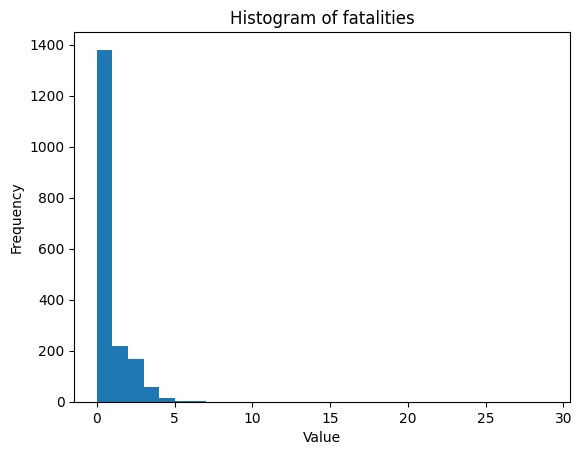

In [72]:
# Make a histogram of values in y
import matplotlib.pyplot as plt

def plot_y(data, title="Histogram of fatalities"):
    bins = range(0, 30, 1)
    plt.hist(data, bins=bins)
    plt.title('Histogram of fatalities')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

vector = np.array(y_test)
log_vector = np.where(vector > 0, np.log(vector), 0)  # Or another value for zero entries

plot_y(log_vector)
## for printing
# for t in zip(log_vector, y_test): print(t)



In [73]:
describe = pd.DataFrame(log_vector)
describe.describe()

,0
count,1846.000000
mean,0.600310
std,1.046074
min,0.000000
25%,0.000000
50%,0.000000
75%,1.098612
max,6.391917


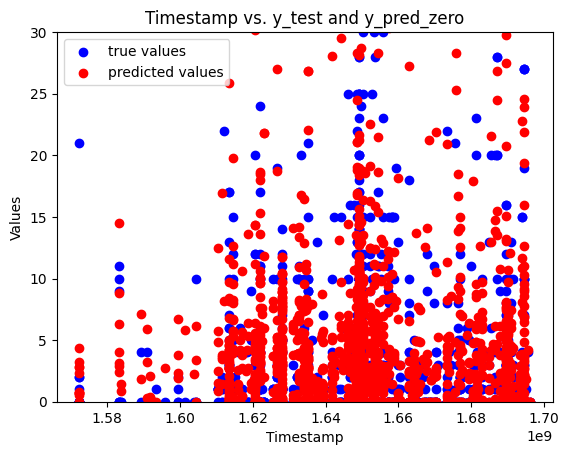

In [55]:
plt.scatter(X_test['TIMESTAMP'], y_test, color='blue', label='true values')
plt.scatter(X_test['TIMESTAMP'], y_pred_zero, color='red', label='predicted values')
plt.ylim(0, 30)
plt.title('Timestamp vs. y_test and y_pred_zero')
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.legend()
plt.show()
